<a href="https://colab.research.google.com/github/Janina712/MLTSA22_JBoecher/blob/main/HW9/HW9_JBoecher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Imports and Set-Up

In [106]:
# import packages
import io
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers 
from keras.layers import Dense, Input, Flatten,\
                   Reshape, LeakyReLU as LR,\
                   Activation, Dropout
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split

In [7]:
# mount drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [8]:
# set path
%cd /content/gdrive/MyDrive/ColabNotebooks/

/content/gdrive/MyDrive/ColabNotebooks


In [195]:
# import dataframe from google drive
from google.colab import files 
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['data_all.csv']))

Saving data_all.csv to data_all (4).csv


In [10]:
df.shape

(47088, 100)

In [11]:
print(f"My dataframe has {df.shape[0]} rows ({df.shape[0]/6} objects and 6 passbands) and {df.shape[1]} columns (time points/mjd).")

My dataframe has 47088 rows (7848.0 objects and 6 passbands) and 100 columns (time points/mjd).


In [12]:
df

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,0.7110,3.540000e-01,-0.81500,0.092000,5.820000e-01,-0.730000,-3.380000e-01,0.87900,9.940000e-02,-4.530000e-01,...,-0.1180,-0.46500,4.470000e-02,0.07810,-0.00757,-5.760000e-03,0.000522,1.870000e-04,-1.500000e-05,-2.650000e-06
1,-0.5760,3.410000e-73,0.00243,0.000058,3.090000e-32,-0.000254,-4.810000e-10,0.00859,3.510000e-145,6.830000e-13,...,0.0012,-0.00851,5.320000e-58,-0.00365,-0.01500,-6.600000e-39,-0.032500,1.090000e-93,0.000000e+00,0.000000e+00
2,-0.7040,-3.780000e-02,0.87100,-0.123000,3.480000e-01,-0.858000,3.950000e-02,0.33600,-4.870000e-02,2.620000e-01,...,0.5800,0.17500,-7.880000e-02,0.01860,-0.56000,6.280000e-01,-0.601000,4.270000e-01,-7.080000e-02,7.170000e-04
3,-0.0701,4.190000e-02,0.94500,0.285000,9.810000e-02,-1.210000,7.370000e-02,0.32200,7.970000e-04,-7.150000e-02,...,0.0799,0.02700,2.540000e-03,-0.15100,-0.38300,2.330000e-02,-0.574000,-4.110000e-03,4.690000e-10,3.940000e-20
4,0.3650,3.570000e-02,1.21000,0.868000,1.060000e-01,-1.380000,1.810000e-01,0.31500,3.890000e-04,-4.190000e-01,...,-0.3790,0.21700,1.380000e-03,-0.64200,-0.51500,2.550000e-02,-0.618000,-6.050000e-04,2.820000e-10,8.260000e-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,0.0469,5.510000e-02,0.06310,0.070600,7.750000e-02,0.083500,8.850000e-02,0.09240,9.510000e-02,9.670000e-02,...,-0.2940,-0.27200,-2.490000e-01,-0.22600,-0.20300,-1.810000e-01,-0.159000,-1.380000e-01,-1.190000e-01,-1.010000e-01
47084,0.2330,2.230000e-01,0.21400,0.204000,1.940000e-01,0.183000,1.730000e-01,0.16200,1.520000e-01,1.410000e-01,...,-0.3170,-0.31000,-3.030000e-01,-0.29600,-0.28900,-2.810000e-01,-0.273000,-2.640000e-01,-2.560000e-01,-2.470000e-01
47085,0.0329,4.290000e-02,0.05350,0.064600,7.570000e-02,0.086500,9.670000e-02,0.10600,1.140000e-01,1.200000e-01,...,-0.4910,-0.47400,-4.530000e-01,-0.43000,-0.40300,-3.750000e-01,-0.344000,-3.130000e-01,-2.810000e-01,-2.490000e-01
47086,-0.1550,-1.550000e-01,-0.15500,-0.155000,-1.550000e-01,-0.155000,-1.550000e-01,-0.15500,-1.550000e-01,-1.550000e-01,...,-0.1550,-0.15500,-1.550000e-01,-0.15500,-0.15500,-1.550000e-01,-0.155000,-1.550000e-01,-1.550000e-01,-1.550000e-01


# 2. Build Autoencoder

In [14]:
# split data into training and validation sets
x_train, x_test = train_test_split(df, test_size=0.25, shuffle = True)

In [15]:
x_train.shape

(35316, 100)

In [212]:
x_test.shape

(11772, 100)

In [35]:
# add callback
# callback prevents overfitting. Interrupts iterations over the data when model stops improving, rather than running all specified epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta = 0.001)

In [193]:
#create model
model = Sequential()
 
#create the model architecture by adding model layers
input_layer = model.add(Dense(100, activation='tanh', input_shape=(100,)))
pre_layer_1 = model.add(Dense(84, activation='tanh'))
pre_layer_2 = model.add(Dense(64, activation='tanh'))
bottle_neck = model.add(Dense(32, activation='tanh', name ="bottle_neck"))
post_layer_1 = model.add(Dense(64, activation='tanh'))
post_layer_2 = model.add(Dense(84, activation='tanh'))
output_layer = model.add(Dense(100, activation='tanh'))
 
#need to choose the loss function, metric, optimization scheme
# adam is the type of gradient descent used for optimization
model.compile(optimizer='adam', loss='mean_squared_error')

In [147]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 100)               10100     
                                                                 
 dense_57 (Dense)            (None, 84)                8484      
                                                                 
 dense_58 (Dense)            (None, 64)                5440      
                                                                 
 dense_59 (Dense)            (None, 32)                2080      
                                                                 
 dense_60 (Dense)            (None, 64)                2112      
                                                                 
 dense_61 (Dense)            (None, 84)                5460      
                                                                 
 dense_62 (Dense)            (None, 100)              

In [302]:
#need to learn what to look for - always plot the loss function!
model2 = model.fit(x_train, x_train, validation_data=(x_test, x_test),
                     epochs=40, batch_size=100, verbose = 1, callbacks=[callback])
#note that the model allows to give a validation test, 
#this is for a 3fold cross valiation: train-validate-test 
#predict
test_y_predictions = model.predict(x_test)

Epoch 1/40
354/354 [==============================] - 4s 8ms/step - loss: 0.1674 - val_loss: 0.1458
Epoch 2/40
354/354 [==============================] - 2s 6ms/step - loss: 0.1401 - val_loss: 0.1392
Epoch 3/40
354/354 [==============================] - 2s 6ms/step - loss: 0.1358 - val_loss: 0.1366
Epoch 4/40
354/354 [==============================] - 2s 5ms/step - loss: 0.1339 - val_loss: 0.1353
Epoch 5/40
354/354 [==============================] - 2s 4ms/step - loss: 0.1327 - val_loss: 0.1346
Epoch 6/40
354/354 [==============================] - 2s 4ms/step - loss: 0.1318 - val_loss: 0.1339
Epoch 7/40
354/354 [==============================] - 1s 4ms/step - loss: 0.1313 - val_loss: 0.1336
Epoch 8/40
354/354 [==============================] - 2s 4ms/step - loss: 0.1309 - val_loss: 0.1332
Epoch 9/40
354/354 [==============================] - 1s 4ms/step - loss: 0.1305 - val_loss: 0.1330
Epoch 10/40
354/354 [==============================] - 1s 4ms/step - loss: 0.1303 - val_loss: 0.1329

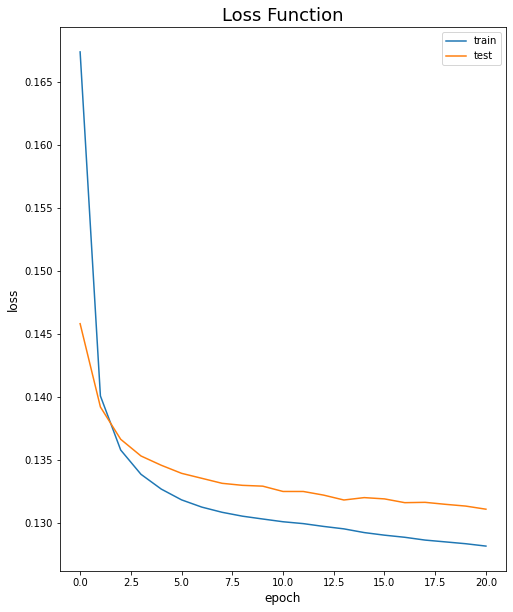

In [315]:
plt.figure(figsize=(8,10))
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('Loss Function', size = 18)
plt.ylabel('loss', size = 12)
plt.xlabel('epoch', size = 12)
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [101]:
ts2plot = 12

In [102]:
obj = int(round((35316 + ts2plot)/6,1))
band = ((35316 + ts2plot)%6) + 1

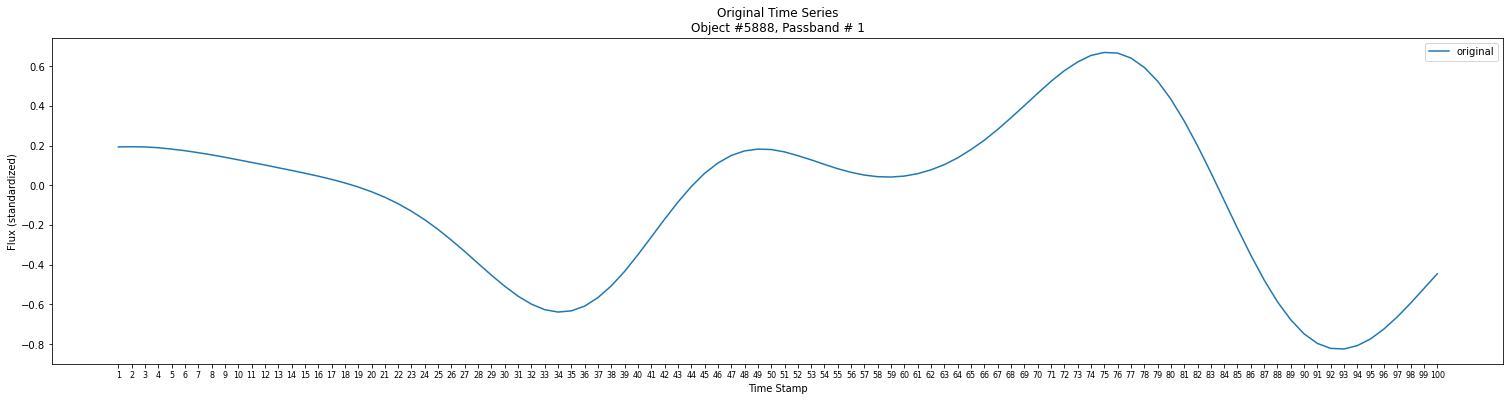

In [104]:
plt.figure(figsize=(26,6))
plt.plot(x_test.iloc[ts2plot], label = "original");
plt.xticks(size = 8)
plt.xlabel("Time Stamp")
plt.ylabel("Flux (standardized)")
plt.title(f"Original Time Series\nObject #{obj}, Passband # {band}")
plt.legend();

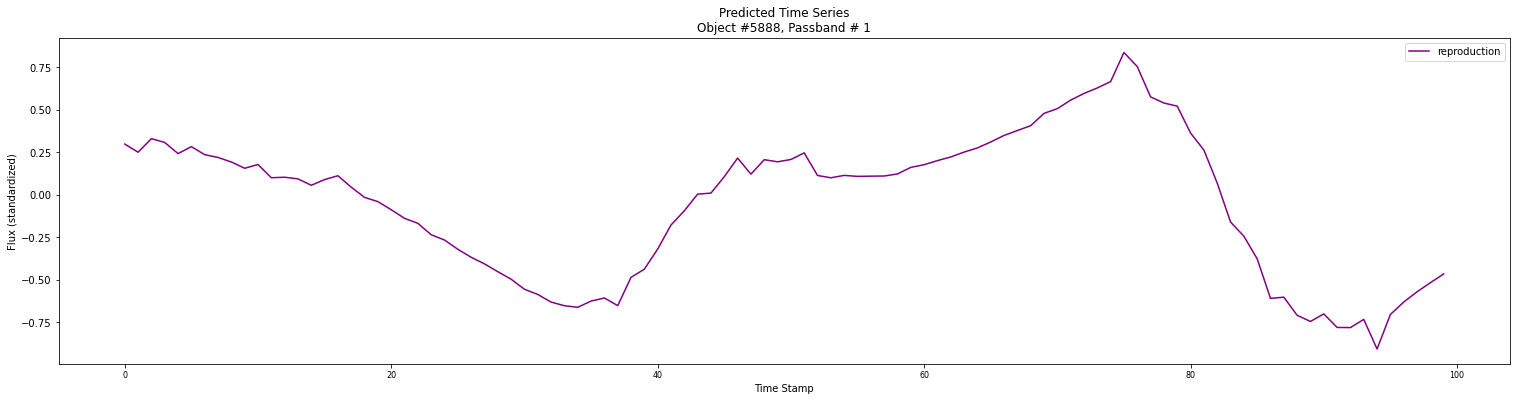

In [105]:
plt.figure(figsize=(26,6))
plt.plot(test_y_predictions[ts2plot], label = "reproduction", color = "purple")
plt.xticks(size = 8)
plt.xlabel("Time Stamp")
plt.ylabel("Flux (standardized)")
plt.title(f"Predicted Time Series\nObject #{obj}, Passband # {band}")
plt.legend();

# 3. Extract Features 
A. Extract Features from Bottleneck

In [287]:
bottleneck_output = model.get_layer('bottle_neck').output
model_bottleneck = Model(inputs = model.input, outputs = bottleneck_output)

bottleneck_predictions = model_bottleneck.predict(df)

In [288]:
bottleneck_predictions.shape

(47088, 32)

In [218]:
bottleneck_predictions[0]

array([-0.23807916,  0.04518425,  0.14493021,  0.19941987,  0.02950279,
       -0.1300732 , -0.01172946, -0.12652364,  0.6299905 ,  0.18572277,
        0.28550166, -0.14162102,  0.35599014, -0.23861821,  0.07314416,
       -0.1752361 , -0.0557333 , -0.01011037, -0.11917275, -0.21286963,
       -0.03374106, -0.11606947,  0.07070268, -0.07285649, -0.08545274,
        0.23011263,  0.27932608,  0.22518891,  0.48549172, -0.0840626 ,
        0.35063455, -0.06236338], dtype=float32)

B. Import Previously Extracted Features

In [205]:
lcvs_features = pd.read_csv("lcvs_features.csv")

In [206]:
lcvs_features

,object_id,passband,mins,maxs,means,means_std,maxs_std,s_std,median_std,decl
0,615.0,0.0,-117.00,125.0,-3.25,-0.00758,0.0273,0.02280,-0.00942,-61.90
1,615.0,1.0,-1100.00,661.0,-386.00,-0.11100,0.1730,0.16300,-0.13900,-27.80
2,615.0,2.0,-682.00,612.0,-134.00,-0.04310,0.1590,0.12400,-0.07880,-6.58
3,615.0,3.0,-531.00,446.0,-121.00,-0.03960,0.1140,0.09100,-0.05070,-45.60
4,615.0,4.0,-422.00,382.0,-56.00,-0.02190,0.0970,0.07920,-0.03480,-63.80
...,...,...,...,...,...,...,...,...,...,...
7843,214000.0,1.0,-4.06,103.0,6.04,-0.00506,0.0213,0.00531,-0.00654,-14.90
7844,214000.0,2.0,-3.71,150.0,11.50,-0.00359,0.0340,0.00825,-0.00651,-62.70
7845,214000.0,3.0,-3.36,134.0,14.90,-0.00267,0.0296,0.00870,-0.00646,-55.70
7846,214000.0,4.0,-7.01,118.0,14.10,-0.00287,0.0253,0.00806,-0.00653,-35.50


C. Combine Bottleneck Features and Previously Extracted Features

In [289]:
# reshape to match the feature dataframe
bottleneck_predictions = bottleneck_predictions.reshape(7848, bottleneck_predictions.shape[1] * 6)

In [291]:
# convert to dataframe to match feature dataframe
bottleneck_predictions = pd.DataFrame(bottleneck_predictions)

In [292]:
bottleneck_predictions.shape

(7848, 192)

In [297]:
#combine
features = pd.concat([lcvs_features, bottleneck_predictions], axis = 1)

In [298]:
features

,object_id,passband,mins,maxs,means,means_std,maxs_std,s_std,median_std,decl,...,182,183,184,185,186,187,188,189,190,191
0,615.0,0.0,-117.00,125.0,-3.25,-0.00758,0.0273,0.02280,-0.00942,-61.90,...,-0.201713,0.034255,0.236295,-0.270838,0.062571,-0.132051,-0.012356,-0.027289,-0.128235,-0.033617
1,615.0,1.0,-1100.00,661.0,-386.00,-0.11100,0.1730,0.16300,-0.13900,-27.80,...,-0.074185,-0.016563,-0.291250,0.262155,0.067294,0.016071,0.276166,0.124639,0.145521,0.272359
2,615.0,2.0,-682.00,612.0,-134.00,-0.04310,0.1590,0.12400,-0.07880,-6.58,...,0.366369,-0.083553,-0.014760,0.014919,0.595424,-0.375520,-0.215569,-0.262652,0.102121,-0.198855
3,615.0,3.0,-531.00,446.0,-121.00,-0.03960,0.1140,0.09100,-0.05070,-45.60,...,0.592343,-0.375776,0.481137,0.300621,0.321030,0.474200,0.372359,-0.254526,-0.617886,0.367307
4,615.0,4.0,-422.00,382.0,-56.00,-0.02190,0.0970,0.07920,-0.03480,-63.80,...,-0.143392,0.329152,0.401314,0.500233,0.790866,-0.521070,-0.586211,-0.172765,0.077749,-0.405221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,214000.0,1.0,-4.06,103.0,6.04,-0.00506,0.0213,0.00531,-0.00654,-14.90,...,-0.397992,0.426068,-0.091413,-0.292976,0.285374,0.504490,0.314843,0.384698,-0.475998,-0.526714
7844,214000.0,2.0,-3.71,150.0,11.50,-0.00359,0.0340,0.00825,-0.00651,-62.70,...,-0.014769,0.458180,-0.123275,0.206263,-0.482178,-0.260620,0.158504,-0.170656,0.162181,-0.258468
7845,214000.0,3.0,-3.36,134.0,14.90,-0.00267,0.0296,0.00870,-0.00646,-55.70,...,0.273840,-0.350788,-0.165034,-0.103208,-0.300122,-0.059545,-0.106952,-0.400110,0.207700,0.068164
7846,214000.0,4.0,-7.01,118.0,14.10,-0.00287,0.0253,0.00806,-0.00653,-35.50,...,-0.073997,0.099118,0.696811,-0.923196,-0.065949,0.534416,0.121762,0.499228,-0.408649,-0.394671


# 4. Random Forest Classification
A. Import targets from metadata

In [109]:
df_meta = pd.read_csv("plasticc_train_metadata.csv.gz")

In [140]:
df_obj = pd.concat([df_meta["object_id"], df_meta["target"]], axis = 1 )

In [141]:
df_obj.head()

,object_id,target
0,615,92
1,713,88
2,730,42
3,745,90
4,1124,90
